# ASTR302 Lab 9: Revisiting a Previous Model Fitting Exercise

In this Lab you will learn about Bayesian inference and recovering model parameters.

## Frequentists vs. Bayesian

We have previously explored how to take our measurements and obtain our best estimates for the desired values and the associated uncertainties. We tended to measure something various times, obtain the mean to give us our best estimate, and use the scatter in those measurements to estimate an uncertainty. This is called the 'frequentist' approach. There is an alternative approach that is a bit more complex but comes with a variety of advantages. This is the Bayesian approach which poses a slightly different question. How likely is it that I measured what I measured given how things work. In other words, given a model should I have expected the measurements I got. An, assuming the model has some free (i.e. unknown) parameters, over what ranges of parameter values are my measurements consistent with the model? Of course, one problem is that one needs a model for what one is observing. This may be easy, for example there may be a physical model that exists already and you can test your measurements against it, or it may be difficult, for example there may be no specific model for it (such as dark energy). In any case, you should at least be able to propose an equation (say a linear one) even if you do not have a physically motivated model in mind. 



## Revisiting the Hubble Parameter

Let us revisit the model fitting that you did in Workbook 5 to recover the Hubble parameter. In particular, in the code below, summarize the results but plotting the data and redoing your linear fit. Print the parameters of the fit (slope and intercept, and uncertainties). You can take all of this from Workbook 5.


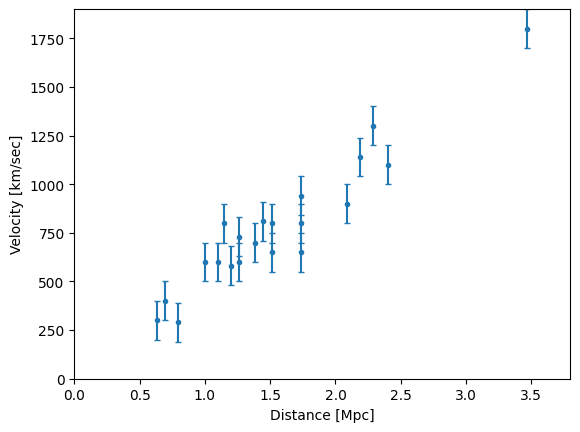

In [1]:
# We'll go ahead and import the usual suspects

import matplotlib.pyplot as plt
import numpy as np

# here is the same data as you used in Workbook 5

velocities = np.array([650,1800,1300,300,800,700,400,600,290,600,940,810,600,730,800,800,580,1100,1140,900,650])
abs_mag = np.array([-13.9,-16.8,-15.7,-13.8,-12.8,-15.0,-14.3,-16.1,-15.5,-15.5,-16.2,-16.4,-14.0,-15.4,-16.0,-16.1,-14.3,-15.9,-17.6,-15.5,-14.5])
app_mag = np.array([12.0,10.9,11.1,10.2,12.5,10.7,9.9,9.4,9.0,9.5,10.0,9.4,11.2,10.1,9.9,10.1,11.1,11.0,9.1,11.1,11.7])

dist = 10**(((app_mag - abs_mag) + 5)/5)/1e6   # to get Mpc

# arbitrarily setting sigma on velocities
sigma = np.ones(len(velocities))*100.0

plt.xlim(0,3.8)
plt.ylim(0, 1900)
plt.errorbar(dist, velocities, yerr=sigma, fmt=".",capsize=2)
plt.ylabel('Velocity [km/sec]')
plt.xlabel('Distance [Mpc]')

# add here your line fitting code
# and plot your best fit line

plt.show()

<div class="alert alert-block alert-success">
Derived Parameters:
</div>

Now, lets work on our Bayesian inference. Conceptually, the task is to take the assumed likilihood distribution of parameter values, plug them into the model, and determine the likelihood of getting the actual measurement. If each measurement is independent, you can multiple the probabilities to get the probability for the entire data set. You may say that you don't know the likelihood distribution of paramter values since you don't even know what the best parameter value is --- in this case you adopt the least constrictive case and assume what are called uniform priors. This just means that any value is as likely as any other (you are being completely agnostic regarding the parameter values). There are other options and we'll get back to that later. 

Now, even if you have a random set of parameter values, calculating the probabilities for many random sets of parameter values is obviously a tedious task. Finding the best set of parameter values is even worse. Well, there are clever algorithms that combine a computer's ability to do random draws and calculate quickly, and clever algorithms that can explore parameter space efficiently to find minima. One common such approach is refered to as Markov Chain Monte Carlo (MCMC). A handy and efficient implementation of this in python is called emcee (https://emcee.readthedocs.io/en/stable/). This link also has useful documentation and examples.

Our first step is to define the function that evaluates the probability of a measurement lying a certain distance away from our model. In the case of a line, and if we believe our uncertainties, then its is just the difference between the model and the data, divided by the uncertainty (all squared and then square rooted to keep things positive definite). If we do the calculation in log space, we get rid of the exponentials and we can simply sum the values (rather than multiplying exponentials). This is why we calculate the log_likelihood.

In [2]:
def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    sigma2 = yerr**2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2)

Next, we define our "priors", which describes the distribution function of our parameters. If we have no additional knowledge, the distribution of these values is uniform. We usually set some limits, just to avoid spending too much time in meaningless areas of parameter space. We're going to only allow the slope to be positive (not too much of a stretch given the plot above) and limit it to less than 1000 km/sec/Mpc. We're also going to limit the intercept to lie somewhere within -500 to 500 km/sec.

In [3]:
def log_prior(theta):
    m, b = theta
# lets just say that we expect the slope to be somewhere between 1 and 1000, and the intercept to be between -500 and 500.    
    if 1 < m < 1000 and -500 < b < 500:
        return 0.0
    return -np.inf

Combining these two together gives us the full probability.

In [6]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)
 

The minimization procedure works more efficiently if we give it reasonable initial guesses for the parameter values. To have such guesses we apply a simple minimization algorithm to the log_likelihood (we make it negative so that a minimization corresponds to the largest probability). 

In [7]:
from scipy.optimize import minimize

np.random.seed(42)  # the minimization uses random steps to find the minimum, so we seed the random sequence

nll = lambda *args: -log_likelihood(*args)

initial = np.array([500, 0]) # even rougher initial guesses for the minimzation routine

soln = minimize(nll, initial, args=(dist, velocities, sigma))

m_ml, b_ml = soln.x  # these will be our starting guess for the parameter values

Now we begin the MCMC process. The process has "walkers" that build the "chain" that explores parameter space. Here we are taking a sample run to see if the procedure is settling down and focusing on the relevant part of parameter space. The cell below this one, plots the results.

In [8]:
!pip install --upgrade pip
!pip install --upgrade emcee
!pip install --upgrade corner  # we'll use corner later

import emcee

#soln.x[0] = 10

pos = soln.x + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(dist, velocities, sigma)
)
sampler.run_mcmc(pos, 5000);

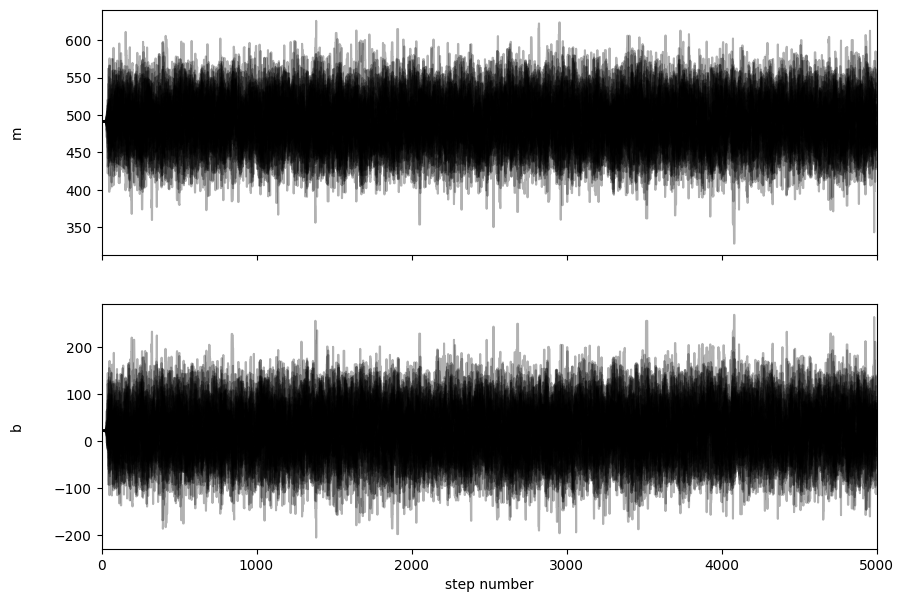

In [9]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

The values bounce around but on average they are stable. If we had given a poorer intial guess, you would have found a drift in the mean until the point at which things settled down. To see this uncomment the line 10 = soln.x[0] after importing emcee in the relevant cell, which will make our initial guess worse, and rerun both cells. Settling down is good because it means that the chain is exploring the relevant part of parameter space. We now calculate the auto-correlation (the number of steps required before the results no longer depend on previous results). 

In [10]:
tau = sampler.get_autocorr_time()
print(tau)

[30.54417869 28.69171812]


We see that about 30 steps are needed before the chain becomes uncorrelated. We should therefore skip at least a few times that number from the beginning so that the results are uncorrelated with out initial guess. The we want to have many samples to explore the parameter space. We choose to skip every 15 steps, again to avoid having results that are strongly correlated with each other.

In [11]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)


(10432, 2)


Now, we'll have a look at what is called a 'corner plot'. It shows the distribution of probabilities in the parameter space by plotting the density of accepted realizations across the parameter space. The highest densities indicate the highest probability for the parameter values to be consistent with the observations. The histogram show the 'marginalized' distributions, which are the density distributions ignoring the other parameter(s). We can set our confidence limits for each of the parameters by quoting, for example, the 16 to 84 percentiles of the distirbutions (corresponding to 1 sigma). 

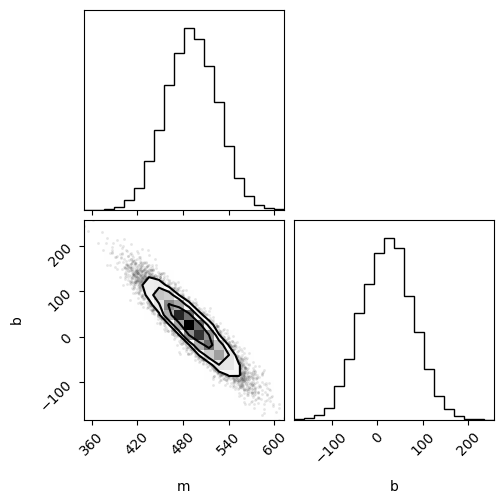

In [12]:
import corner

fig = corner.corner(
    flat_samples, labels=labels
);

We show below what this range of parameters means in terms of the allowed set of linear fits and then quote the parameter values we derive (1 sigma error range).

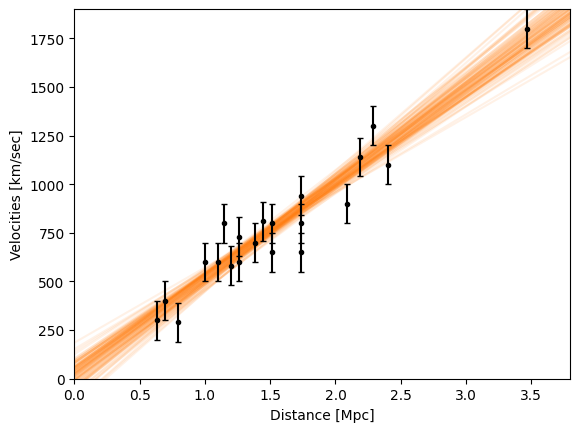

In [13]:
x0 = np.linspace(0, 5, 500)
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(dist, velocities, yerr=sigma, fmt=".k", capsize=2)
plt.xlim(0,3.8)
plt.ylim(0, 1900)
plt.xlabel("Distance [Mpc]")
plt.ylabel("Velocities [km/sec]");

In [14]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))



<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_6028/1956489098.py:6: SyntaxWarning: invalid escape sequence '\m'
  txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Nevermind that we still get the wrong result for the Hubble parameter - better model fitting doesn't fix a systematic error. Let's work instead on thinking of ways to improve the precision of the measurement. We could propose to observe these objects again to reduce the velocity uncertainty - that would certainly help. Lets quantify that. Let's say we could reduce the uncertainty in each measurement from 100 km/s to 30 km/s. How much does that reduce our uncertainties in m (i.e. the Hubble parameter) by? Now lets say that it seems to us that this observing program would require quite a bit of telescope time and it might be difficult to obtain that much time. We could instead spend significant less time focused on one object and reduce its velocity uncertainty to 5 km/sec. Which object would you pick? How would that affect our precision? Which approach would you advocate to the telescope allocation committee?

<div class="alert alert-block alert-success">
Make you convincing argument one way or another to get a high precision Hubble parameter measurement:
</div>

Now let's take a different approach. Can we improve the precision by thinking a bit more about our priors. The intercept represents the expansion velocity at the origin (i.e. us). That has to be zero! Let's change our prior so that we only allow values of b within +-50 km/sec of 0. What happens to the uncertainty on m? What happens to the corner plot? What happens to the uncertainty on b? 

<div class="alert alert-block alert-success">
Why or why not do you think this is a good approach in lowering the uncertainty on m? Give both pluses and minuses?
</div>

## Conclusion: 

<div class="alert alert-info"> Save your notebook.  Append your LastNameFirstInitial to the filename and submit via D2L. </div>